# CNN + Data Augmentation 練習

In [1]:
import matplotlib.pyplot as plt
'''
繁體中文顯示設定
'''
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import math
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# import tensorflow as tf
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [3]:
# import package
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)

## handwritten 資料讀入及前處理

In [4]:
data_path = "./cleaned_data/"

x_data_list = []
y_data_list = []
class_map = {}
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])
            if roots.split("/")[-1] not in class_map:
                class_map[roots.split("/")[-1]]=each.split('_')[0]
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})

In [5]:
data.groupby('class').count()['file']

class
丁    100
三    100
上    100
不    100
世    100
    ... 
黃    100
黎    100
鼎    100
齊    100
龍    100
Name: file, Length: 800, dtype: int64

In [6]:
img_size = 224

(224, 224)


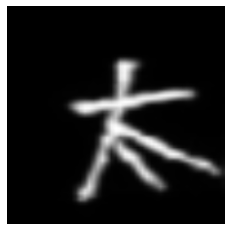

In [7]:
img = cv2.imread(x_data_list[100], 0)
img = cv2.resize(img, (img_size, img_size))
print(img.shape)
plt.imshow(img/255, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(data,
                                        test_size=0.2,
                                        random_state=42,
                                        stratify=data['class'].values)

In [9]:
train_list.groupby('class').count()

,file
class,
丁,80
三,80
上,80
不,80
世,80
...,...
黃,80
黎,80
鼎,80


In [10]:
val_list.groupby('class').count()

,file
class,
丁,20
三,20
上,20
不,20
世,20
...,...
黃,20
黎,20
鼎,20


## 讀入 Pre-trained Model

In [11]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [12]:
img_size = 224
num_class = len(data['class'].unique())

In [13]:
# model_name = 'resnet50'
# base_model = ResNet50(weights='imagenet', include_top=False,
#                       input_shape=(img_size, img_size, 3))

# x = GlobalAveragePooling2D()(base_model.output)
# outputs = Dense(num_class, activation='softmax')(x)
# model = Model(inputs=base_model.inputs, outputs=outputs)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])

In [14]:
# with strategy.scope():
model_name = 'effB0'
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(base_model.output)
outputs = Dense(num_class, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# 決定 Pre-Train 參數量

In [15]:
base_model.trainable = True

# trainable_layer = 10
# for layer in base_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

# Data Augmentation

In [16]:
batch_size = 64
num_steps = len(train_list) // batch_size 
num_epochs = 50

In [17]:
def bbox_by_black(img):
    
    block=2
    center_distance_ratio=1/4
    
    top=0
    bot=0
    left=0
    right=0

    for y in range(int(img[:,:,0].shape[0]/2+img[:,:,0].shape[0]*center_distance_ratio),img[:,:,0].shape[0]-1):
        if img[y,:,0].mean()<block:
            top=y
            break
    if top==0:
        top=img[:,:,0].shape[0]


    for y in range(int(img[:,:,0].shape[0]/2-img[:,:,0].shape[0]*center_distance_ratio),0,-1):
        if img[y,:,0].mean()<block:
            bot=y
            break


    for x in range(int(img[bot:top,:,0].shape[1]/2+img[bot:top,:,0].shape[1]*center_distance_ratio),img[bot:top,:,0].shape[1]-1):
        if img[bot:top,x,0].mean()<block:
            right=x
            break

    if right==0:
        right=img[bot:top,:,0].shape[1]


    for x in range(int(img[bot:top,:,0].shape[1]/2-img[bot:top,:,0].shape[1]*center_distance_ratio),0,-1):
        if img[bot:top,x,0].mean()<block:
            left=x
            break
    
    return left,right,bot,top

In [18]:
def preprocess_input(img):
    thresh = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x1, x2, y1, y2 = bbox_by_black(thresh)
    img = img[y1:y2, x1:x2]
#     img -= (103.939, 116.779, 123.68)
    img = tf.image.resize_with_pad(img, 224, 224)
    return img

In [19]:
train_datagen = ImageDataGenerator(                            
                                   rotation_range=10,
                                   fill_mode='constant',
                                   cval = 0,
                                   preprocessing_function=preprocess_input
                                  )
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    x_col="file",
                                                    y_col="class",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = datagen.flow_from_dataframe(dataframe=val_list,
                                            x_col="file",
                                            y_col="class",
                                            target_size=img_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 64000 validated image filenames belonging to 800 classes.
Found 16000 validated image filenames belonging to 800 classes.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


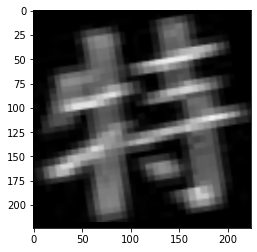

In [21]:
plt.imshow(next(train_generator)[0][0]/255)

In [22]:
all_generator = datagen.flow_from_dataframe(dataframe=data,
                                            x_col="file",
                                            y_col="class",
                                            target_size=img_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 80000 validated image filenames belonging to 800 classes.


## 開始訓練模型

In [23]:
def callbacks_fun(model_name, img_size):
    model_dir = f'model-logs/{model_name}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    logfiles = model_dir + '/basic_model'
    modelfiles = model_dir + f'/{model_name}_{img_size}.h5'
    model_cbk = TensorBoard(log_dir=logfiles, histogram_freq=1)
    model_mckp = ModelCheckpoint(modelfiles,
                                 monitor='val_accuracy',
                                 save_best_only=True)  
    LR_decay = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 verbose=1,
                                 factor=0.8)

    return [model_cbk, model_mckp, LR_decay]

In [24]:
# 設定 cllbacks
callbacks_list = callbacks_fun(model_name, img_size)

In [25]:
history = model.fit(train_generator,
                    steps_per_epoch=num_steps,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/50
   1/1000 [..............................] - ETA: 0s - loss: 6.7808 - accuracy: 0.0000e+00WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1000/1000 [==============================] - 1605s 2s/step - loss: 1.4345 - accuracy: 0.7224 - val_loss: 0.3207 - val_accuracy: 0.9193
Epoch 2/50
1000/1000 [==============================] - 1602s 2s/step - loss: 0.1946 - accuracy: 0.9516 - val_loss: 0.3254 - val_accuracy: 0.9181
Epoch 3/50
1000/1000 [==============================] - 1602s 2s/step - loss: 0.1259 - accuracy: 0.9673 - val_loss: 0.1860 - val_accuracy: 0.9538
Epoch 4/50
1000/1000 [==============================] - 1601s 2s/step - loss: 0.0953 - accuracy: 0.9747 - val_loss: 0.2056 - val_accuracy: 0.9511
Epoch 5/50
1000/1000 [==========================

## 訓練結果視覺化

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


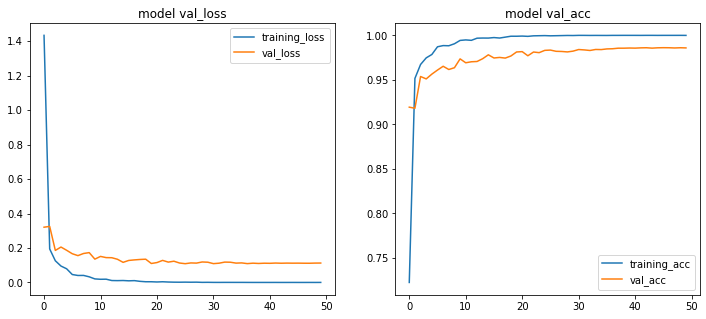

In [26]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [26]:
model = load_model(f'./model-logs/{model_name}/{model_name}_{img_size}.h5')

In [ ]:
# val_generator.batch_size = 1
# val_generator.reset()

In [ ]:
# err_idx = np.where(y_val!=y_pred)[0]
# n = len(err_idx)
# error_img = []
# for i, idx in enumerate(err_idx):
#     error_img.append(val_list['file'].values[idx].split('/')[-1] + '-' + class_names[y_pred[idx]])

In [27]:
y_pred_prob = model.predict(all_generator, verbose=1)
y_pred = y_pred_prob.argmax(-1)
y_val = all_generator.classes

1250/1250 [==============================] - 1410s 1s/step


In [28]:
class_names = np.array(list(val_generator.class_indices.keys()))

In [ ]:
# def get_preds_classes(preds, classes, top_k=3):
#     top_k_idx = preds.argsort()[:,::-1][:, :top_k]
#     top_k_classes = classes[top_k_idx]
#     top_k_probs = preds[:, top_k_idx]
#     return (top_k_classes, top_k_probs)

In [ ]:
# outputs = get_preds_classes(y_pred_prob, class_names, top_k=3)

In [29]:
err_idx = np.where(y_val!=y_pred)[0]
n = len(err_idx)

In [30]:
error_img = []
for i, idx in enumerate(err_idx):
    error_img.append(data['file'].values[idx].split('/')[-1] + '-' + class_names[y_pred[idx]])

In [24]:
error_img = ['10307_翠.png-築',
 '58618_政.png-致',
 '24162_玉.png-五',
 '42109_珍.png-玲',
 '48966_天.png-大',
 '68096_戶.png-力',
 '37393_戶.png-貴',
 '10017_文.png-不',
 '12749_堂.png-富',
 '18754_寓.png-勇',
 '13112_藍.png-蓉',
 '35871_介.png-公',
 '47349_銓.png-鈞',
 '6657_菊.png-氣',
 '33371_村.png-林',
 '10686_房.png-方',
 '66322_實.png-買',
 '60105_實.png-系',
 '62631_實.png-寶',
 '26346_實.png-寶',
 '62265_鳳.png-騰',
 '33803_記.png-煜',
 '35163_林.png-城',
 '63060_林.png-飛',
 '51516_業.png-有',
 '1346_游.png-沛',
 '44677_訊.png-升',
 '53316_訊.png-資',
 '51125_份.png-股',
 '68250_董.png-黃',
 '7365_機.png-茂',
 '64906_容.png-客',
 '64512_玲.png-冷',
 '40446_樂.png-專',
 '48152_耀.png-燿',
 '7874_苗.png-貨',
 '39441_士.png-土',
 '56368_師.png-計',
 '55699_徐.png-得',
 '46864_枝.png-英',
 '47567_投.png-場',
 '50699_消.png-清',
 '21928_隆.png-陽',
 '66554_居.png-房',
 '14990_食.png-公',
 '16015_盈.png-孟',
 '10477_療.png-煒',
 '51689_療.png-齊',
 '44567_有.png-限',
 '44324_有.png-車',
 '62450_捷.png-婕',
 '47332_里.png-男',
 '43315_碩.png-顧',
 '54297_連.png-視',
 '28553_化.png-代',
 '1767_化.png-仕',
 '39133_鐵.png-樹',
 '15468_楊.png-鵬',
 '22762_傅.png-博',
 '11236_傅.png-傳',
 '45553_傅.png-傳',
 '60295_施.png-海',
 '12638_蓮.png-連',
 '9248_蓮.png-達',
 '64111_飲.png-啟',
 '61190_湯.png-鼎',
 '55934_湯.png-進',
 '64811_診.png-治',
 '1160_朱.png-珠',
 '64696_總.png-潔',
 '55704_柏.png-柯',
 '1005_音.png-部',
 '37094_音.png-樂',
 '44398_葳.png-成',
 '15684_系.png-柔',
 '33395_土.png-士',
 '36788_土.png-士',
 '66519_坊.png-巧',
 '50208_安.png-色',
 '10775_劉.png-鄧',
 '62306_王.png-玉',
 '40441_芬.png-空',
 '36211_泓.png-弘',
 '16003_球.png-沛',
 '48682_雪.png-雲',
 '47604_部.png-邦',
 '57620_原.png-厚',
 '56299_風.png-具',
 '62026_丞.png-孟',
 '50400_教.png-敬',
 '11500_教.png-淑',
 '41465_委.png-李',
 '45454_保.png-傑',
 '41876_呈.png-堅',
 '14170_呈.png-皇',
 '6157_託.png-信',
 '4894_亞.png-福',
 '65227_漢.png-圓',
 '12826_翁.png-爾',
 '56886_翁.png-舜',
 '28931_平.png-年',
 '24664_皇.png-全',
 '15493_美.png-業',
 '97_億.png-僑',
 '22440_育.png-奇',
 '50121_科.png-料',
 '56735_恩.png-思',
 '6474_恩.png-資',
 '49920_材.png-妹',
 '41968_兒.png-允',
 '60028_寶.png-寬',
 '17502_寶.png-慶',
 '43986_車.png-汽',
 '33767_蔣.png-蕭',
 '45072_威.png-企',
 '56163_承.png-柔',
 '53012_進.png-維',
 '53137_女.png-世',
 '41408_勳.png-泉',
 '62618_勤.png-動',
 '14217_勤.png-勳',
 '9407_主.png-呈',
 '19656_暘.png-陽',
 '3164_欽.png-鈦',
 '39618_員.png-會',
 '44270_慶.png-廣',
 '16532_慶.png-詹',
 '14648_張.png-泰',
 '38385_日.png-王',
 '36012_君.png-局',
 '59816_克.png-志',
 '45854_克.png-思',
 '51745_韋.png-萬',
 '22614_韋.png-盧',
 '15982_小.png-山',
 '59242_龍.png-謝',
 '14337_蘭.png-暉',
 '41008_永.png-禾',
 '49080_石.png-不',
 '48962_店.png-香',
 '14981_余.png-金',
 '40286_余.png-全',
 '43024_心.png-仙',
 '5067_計.png-會',
 '20258_密.png-思',
 '27313_曾.png-會',
 '38159_曾.png-專',
 '8826_影.png-彰',
 '53398_呂.png-昌',
 '6249_芸.png-芳',
 '13292_傳.png-傅',
 '5311_義.png-儀',
 '7578_行.png-竹',
 '39883_清.png-消',
 '36683_財.png-訊',
 '17517_揚.png-湯',
 '51597_潘.png-洋',
 '38790_采.png-禾',
 '39116_采.png-禾',
 '36529_采.png-宋',
 '2624_藥.png-樂',
 '43139_真.png-古',
 '12736_春.png-喬',
 '58445_技.png-投',
 '392_仕.png-任',
 '42071_孟.png-韋',
 '9037_證.png-澄',
 '50874_白.png-自',
 '60282_白.png-戶',
 '12981_白.png-自',
 '1721_白.png-百',
 '47226_所.png-務',
 '13682_賴.png-娟',
 '40703_賴.png-柏',
 '41425_秀.png-告',
 '46306_儀.png-器',
 '55626_場.png-揚',
 '59862_生.png-多',
 '50133_環.png-理',
 '39547_僑.png-嬌',
 '56587_鐘.png-錦',
 '50016_鐘.png-鍾',
 '55306_鐘.png-鍾',
 '16472_宋.png-朱',
 '7747_昆.png-紀',
 '12653_企.png-正',
 '46712_合.png-分',
 '20619_合.png-居',
 '57_巨.png-戶',
 '55078_幼.png-竹',
 '61310_全.png-室',
 '39301_縣.png-財',
 '58686_上.png-恩',
 '55266_蔡.png-東',
 '15674_吉.png-言',
 '47239_程.png-任',
 '50218_塑.png-製',
 '19854_塑.png-膠']

In [25]:
sort_img = sorted(error_img)

In [26]:
files = {'00000-08000':[],
         '08001-16000':[],
         '16001-24000':[],
         '24001-32000':[],
         '32001-40000':[],
         '40001-48000':[],
         '48001-56000':[],
         '56001-68803':[]}
for file in sort_img:
    file_num = int(file.split('_')[0])
    if 0 <= file_num <= 8000:
        files['00000-08000'].append(file)
    elif 8001 <= file_num <= 16000:
        files['08001-16000'].append(file)
    elif 16001 <= file_num <= 24000:
        files['16001-24000'].append(file)
    elif 24001 <= file_num <= 32000:
        files['24001-32000'].append(file)
    elif 32001 <= file_num <= 40000:
        files['32001-40000'].append(file)
    elif 40001 <= file_num <= 48000:
        files['40001-48000'].append(file)
    elif 48001 <= file_num <= 56000:
        files['48001-56000'].append(file)
    elif 56001 <= file_num <= 68803:
        files['56001-68803'].append(file)

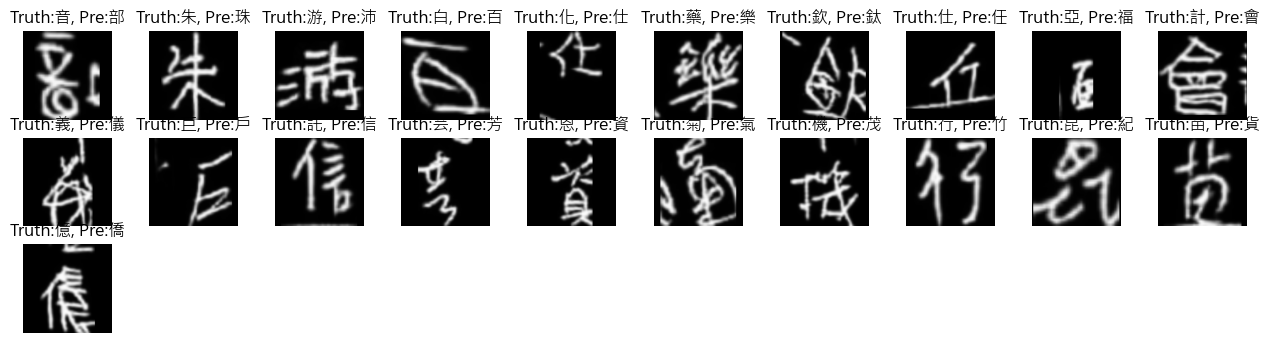

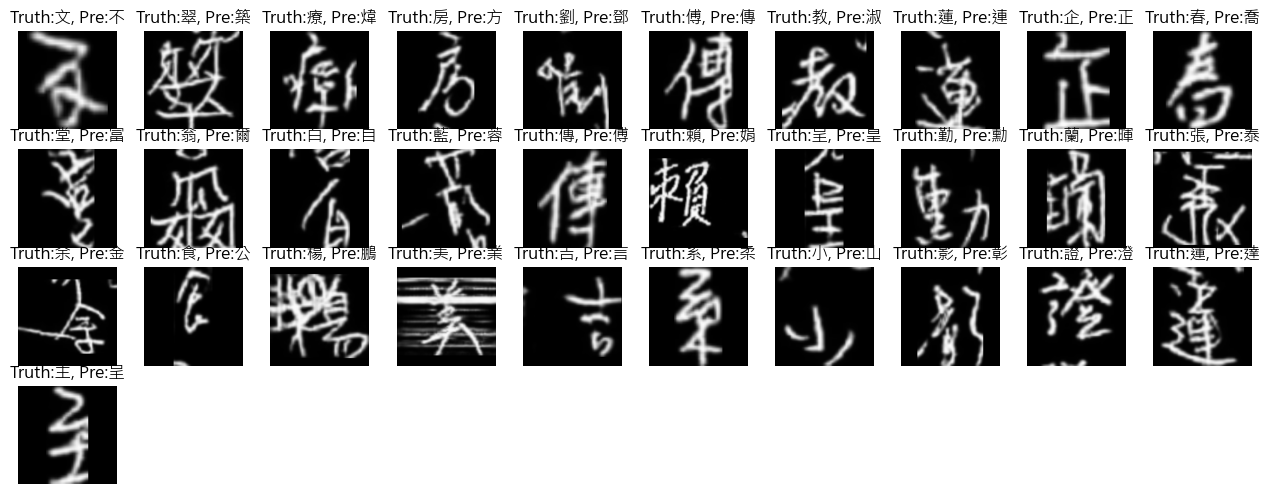

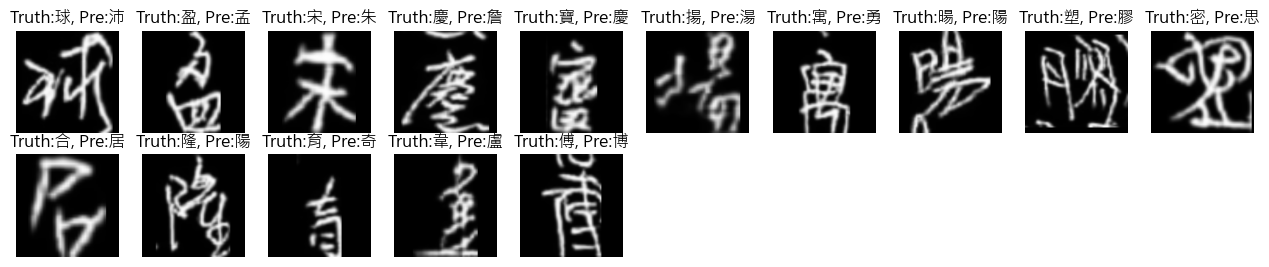

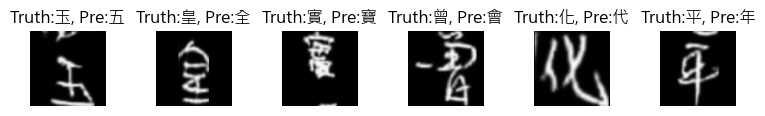

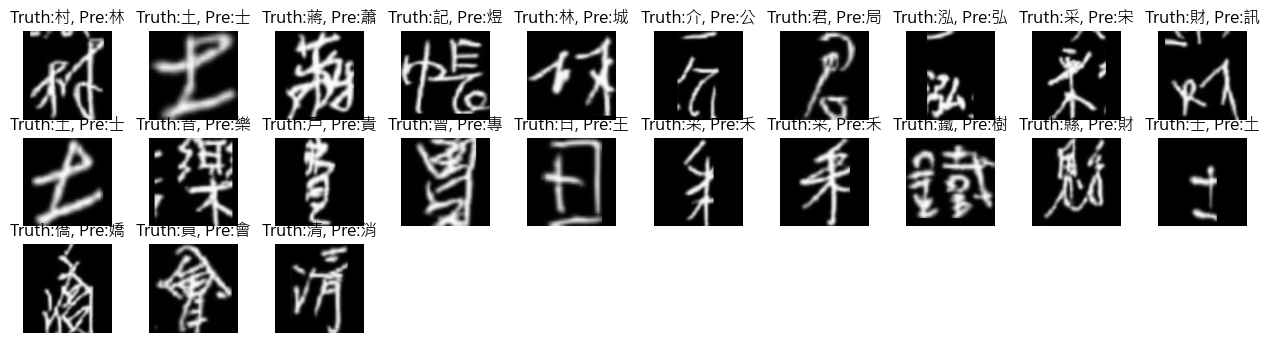

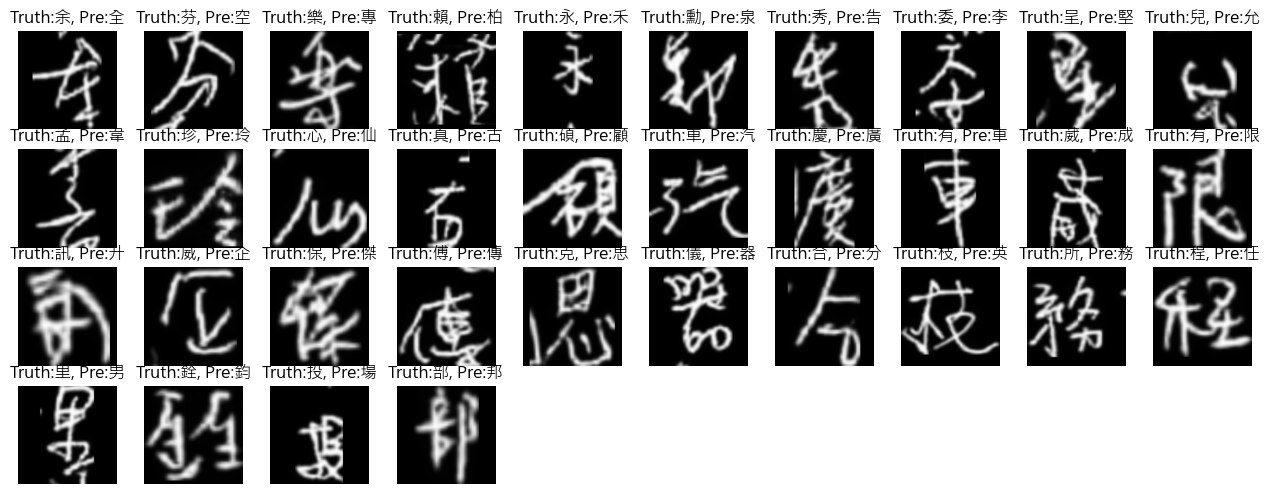

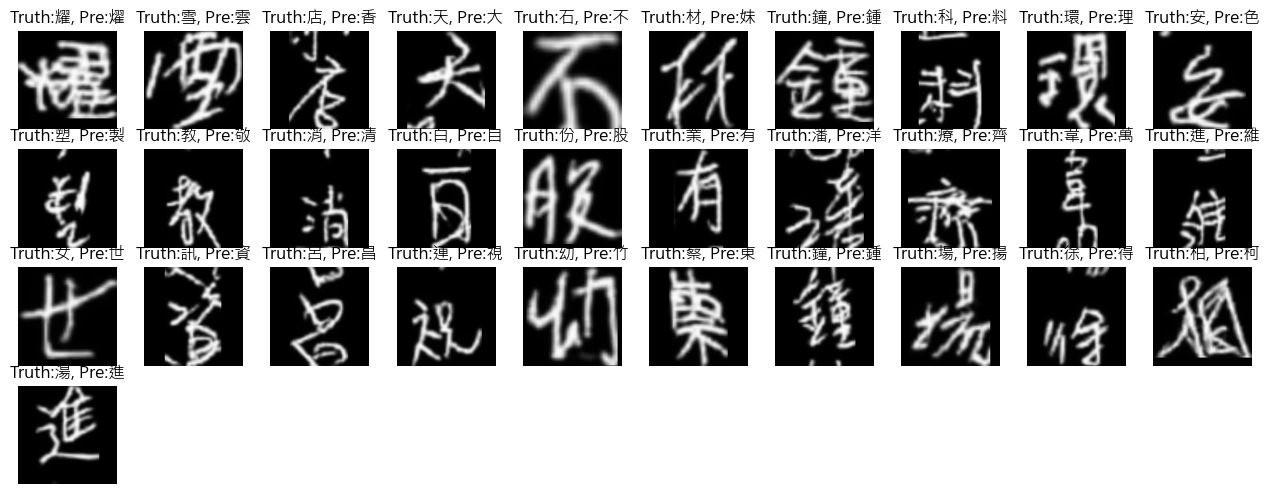

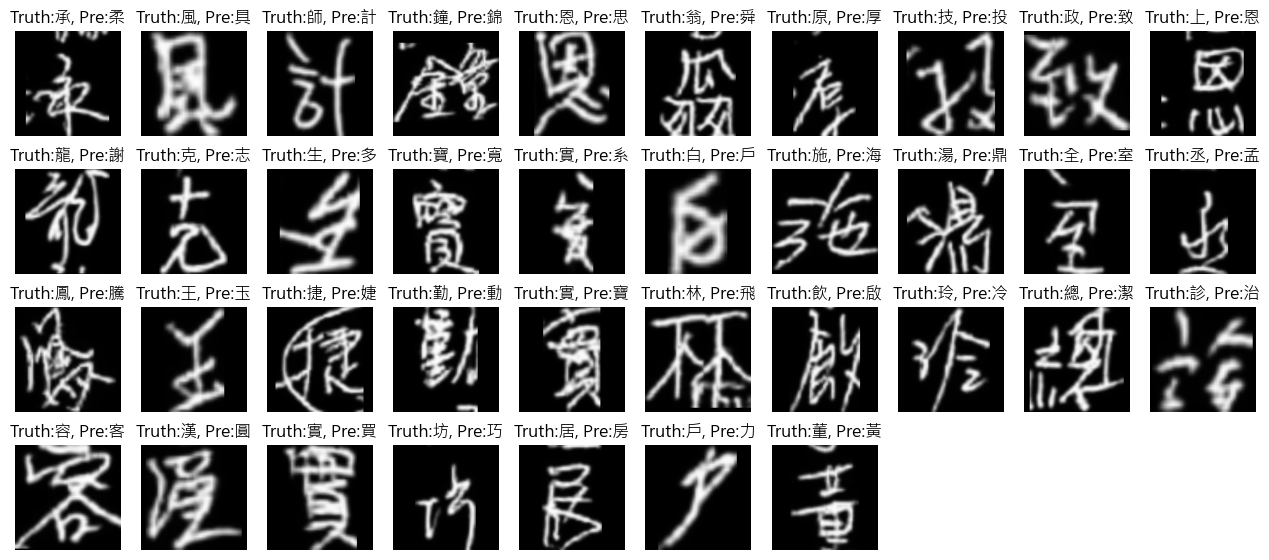

In [27]:
for key, values in files.items():
    # write file path to txt
    textfile = open(key + '.txt', 'w')
    for i in values:
        textfile.write(i[:-2] + "\n")
    textfile.close()
    
    if len(values)!=0:
        # plot the error img
        fig = plt.figure(figsize=(16, len(values)//5), dpi=100)
        for i, file in enumerate(values):
            img = cv2.imread('cleaned_data/' + file.split('_')[-1][0] + '/' + file[:-2])
            img = preprocess_input(img)
            plt.subplot(math.ceil(len(values)/10), 10, i+1)
            plt.title('Truth:'+file.split('_')[-1][0] +', Pre:'+file[-1])
            plt.imshow(img/255, cmap='gray')
            plt.axis('off')
        plt.savefig(key + '.png')

In [ ]:
observe = data[data['class'] == '池']

In [ ]:
fig = plt.figure(figsize=(16, len(observe)//5), dpi=100)
for i, file in enumerate(observe['file']):
    img = cv2.imread(file)
    img = preprocess_input(img)
    plt.subplot(math.ceil(len(observe)/10), 10, i+1)
    plt.title('Truth:'+file.split('_')[-1][0])
    plt.imshow(img/255, cmap='gray')
    plt.axis('off')

In [ ]:
print(len(data[data['class'] == '治']))
print(len(data[data['class'] == '洲']))